# 构建数据集

In [1]:
import pandas as pd

X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'], 
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})

print(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


In [2]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

# 填充定性特征

In [3]:
most_frequent=X['city'].value_counts()

In [4]:
#寻找最常见的元素
X['city'].value_counts().index[0]

'tokyo'

In [5]:
X['city'].fillna(most_frequent)

0            tokyo
1              NaN
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

# 自定义分类填充器

In [6]:
# 创建自定义分类填充器
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [7]:
# 在列上应用自定义分类（定性）填充器
cci = CustomCategoryImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


# 自定义定量填充器

In [8]:
# 自定义定量填充器
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [9]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')
cqi.transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


# 定类等级编码0-1编码


In [10]:
pd.get_dummies(X, 
               columns = ['city', 'boolean'],  # 要虚拟化的列
               prefix_sep='_') # 前缀（列名）和单元格值之间的分隔符

,ordinal_column,quantitative_column,city_london,city_san francisco,city_seattle,city_tokyo,boolean_no,boolean_yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


# 有序变量编码

In [11]:
#创建列表
ordering = ['dislike', 'somewhat like', 'like'] 
# 将ordering映射到顺序列
print(X['ordinal_column'].map(lambda x: ordering.index(x)))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [12]:
#流水化
# 将自定义标签编码器放进流水线中
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [13]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


# 将连续变量分箱

In [14]:
# 默认的类别名是分箱
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [20]:
# 默认的类别名是分箱，不使用标签
pd.cut(X['quantitative_column'], bins=3 ,labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [39]:
import pandas as pd
df= pd.read_csv(r"D:\Amy\activity_recognizer\1.csv")
df.columns=['index', 'x', 'y', 'z', 'activity']

#x轴加速器，y轴加速器，z轴加速器，标签1在电脑前工作;2站立、走路和上下楼梯;3站立;4走路;5上下楼梯;6与人边走边聊;7站立着讲话。

In [40]:
df.head()

,index,x,y,z,activity
0,1.0,1667,2072,2047,1
1,2.0,1611,1957,1906,1
2,3.0,1601,1939,1831,1
3,4.0,1643,1965,1879,1
4,5.0,1604,1959,1921,1


In [41]:
#计算每个动作的百分比
df['activity'].value_counts(normalize=True)

7    0.515372
1    0.207237
4    0.165292
3    0.068794
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

X = df[['x', 'y', 'z']]
# 删除响应变量，建立特征矩阵
y = df['activity']

#尝试使用knn进行分类分析
knn_params = {'n_neighbors':[3, 4, 5, 6]}  #使用邻居个数
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)
print('最佳的准确率 与 最佳参数 \n',grid.best_score_, grid.best_params_)

#74%的准确率比空准确率51.3%高很多，说明模型是有效的

最佳的准确率 与 最佳参数 
 0.740356923076923 {'n_neighbors': 5}


# 生成多项式特征

In [56]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X)
pd_ys=pd.DataFrame(X_poly, columns=poly.get_feature_names())
#degree是多项式特征的阶数，默认值是2
#interaction_only是布尔值：如果为True（默认False），表示只生成互相影响/交互的特征，也就是不同阶数特征的乘积
#include_bias也是布尔值：如果为True（默认），会生成一列阶数为0的偏差列，也就是说列中全是数字1

<AxesSubplot:>

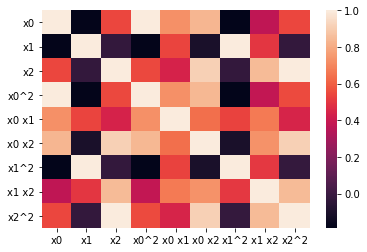

In [57]:
import seaborn as sns
sns.heatmap(pd_ys.corr())

In [59]:
#尝试使用knn进行分类分析
knn_params = {'n_neighbors':[3, 4, 5, 6]}  #使用邻居个数
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(pd_ys, y)
print('最佳的准确率 与 最佳参数 \n',grid.best_score_, grid.best_params_)

最佳的准确率 与 最佳参数 
 0.7407507692307692 {'n_neighbors': 5}


# 文本专用特征构造